<a href="https://colab.research.google.com/github/arunangshudutta/DA6401_assignments/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
#import wandb

In [ ]:
# load dataset
from keras.datasets import fashion_mnist

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

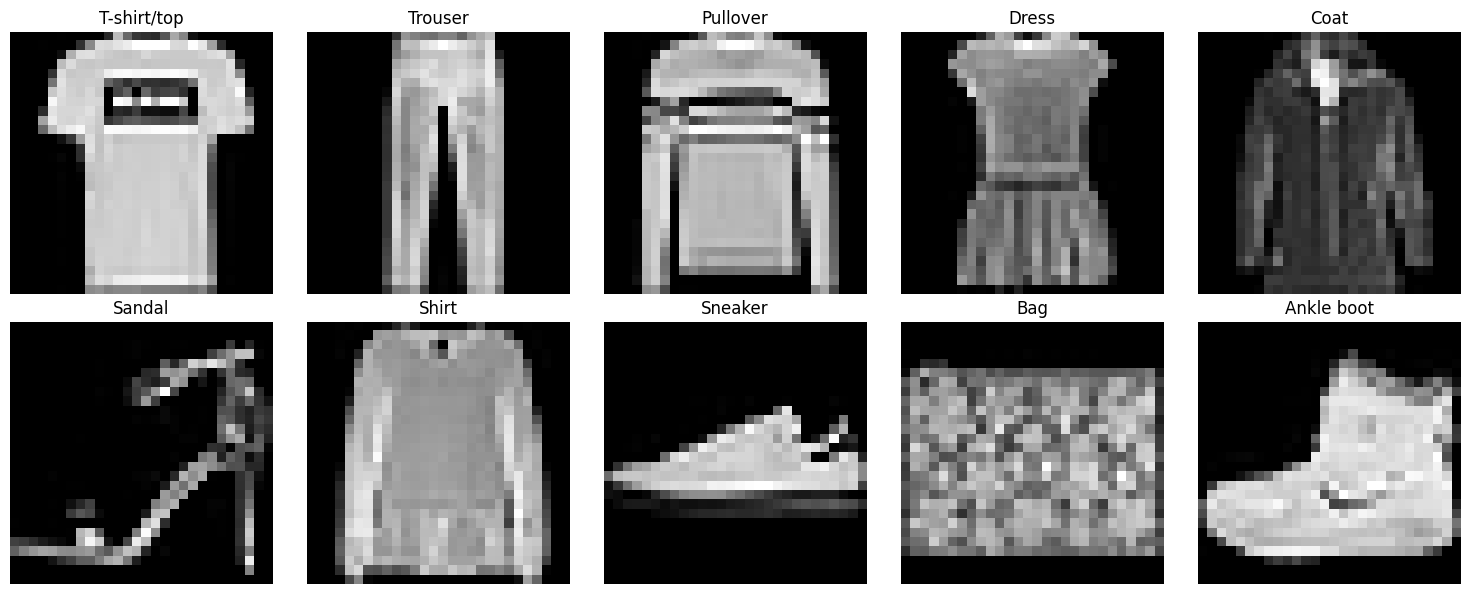

In [ ]:
# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a 2x5 grid for displaying images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Display one image from each class
for i in range(len(class_names)):
    # Find the first occurrence of the class in the dataset
    idx = np.where(train_labels == i)[0][0]

    # Display the image
    axes[i].imshow(train_images[idx], cmap='gray')
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print(train_images[0].shape)

(28, 28)


In [ ]:
test_lables.shape

(10000,)

In [ ]:
def one_hot_encode(integers, num_classes=None):
    if num_classes is None:
        num_classes = np.max(integers) + 1
    return np.eye(num_classes)[integers]

In [ ]:
def weights_initialization(num_neurons, initializer):
  """
  num_neurons = list of number of neurons at each layer starting from the input layer and ending at output layer
  initializer = 'random' or 'xavier'

  Returns: initialized weight matrices and bias vectors
  """
  mean=0
  std_dev=1

  W_matrices = []
  b_vectors = []

  for i in range(len(num_neurons)-1):
    rows = num_neurons[i+1]
    cols = num_neurons[i]

    if initializer == 'random':

      weight_matrix = np.random.normal(mean, std_dev, size=(rows, cols))

    elif initializer == 'xavier':

      upper_bound = np.sqrt(6.0/(rows + cols))
      lower_bound = -1*upper_bound
      weight_matrix = np.random.uniform(low = lower_bound, high = upper_bound, size = (rows, cols))

    else:
      print('initializer invalid')


    bias_vector = np.zeros((rows,1))

    W_matrices.append(weight_matrix)
    b_vectors.append(bias_vector)


  return W_matrices, b_vectors

In [ ]:
# ACTIVATION FUNCTIONS
def relu(x):
  """
  Rectified Linear Unit (ReLU) activation function
  """
  return np.maximum(0, x)

def sigmoid(x):
  """
  Sigmoid activation function
  """
  # x = np.float128(x)
  return 1 / (1 + np.exp(-x))

def tanh(x):
  """
  Hyperbolic tangent (tanh) activation function
  """
  # x = np.float128(x)
  return np.tanh(x)
def softmax(x):

  """
  Softmax function for output layer
  """
  # x = np.float128(x)
  return np.exp(x) / np.sum(np.exp(x), axis=0)

def activation_output(x, activation_function):
  """
  activation_function = 'relu', 'sigmoid', 'tanh'
  """
  if activation_function == 'relu':
    return relu(x)
  elif activation_function == 'sigmoid':
    return sigmoid(x)
  elif activation_function == 'tanh':
    return tanh(x)
  elif activation_function == 'softmax':
    return softmax(x)
  else:
    print('activation function invalid')

# DERIVATIVE OF ACTIVATION FUNCTION
def sigmoid_derivative(x):
  s = sigmoid(x)
  return s * (1 - s)

def tanh_derivative(x):
  t = tanh(x)
  return 1 - t**2

def relu_derivative(x):
  return np.where(x > 0, 1, 0)

def activation_derivative(x, activation_function):
  """
  activation_function = 'relu', 'sigmoid', 'tanh'
  """
  if activation_function == 'relu':
    return relu_derivative(x)
  elif activation_function == 'sigmoid':
    return sigmoid_derivative(x)
  elif activation_function == 'tanh':
    return tanh_derivative(x)
  else:
    print('activation function invalid')

In [ ]:
def layer_output_FP(x, weight_matrix, bias_vector, activation_function):
  pre_activation = np.add(np.matmul(weight_matrix, x), bias_vector)
  post_activation = activation_output(pre_activation, activation_function)
  return pre_activation, post_activation

def forward_propagation(ip_data, W_matrices, b_vectors, activation_functions):
  """
  forward propagation
  """

  layer_op = []
  layer_op.append(ip_data)

  layer_ip = []

  for i in range(len(W_matrices)):

    weight_matrix = W_matrices[i]
    bias_vector = b_vectors[i]

    activation_function = activation_functions[i]

    pre_activation, post_activation = layer_output_FP(layer_op[i], weight_matrix, bias_vector, activation_function)

    layer_op.append(post_activation)
    layer_ip.append(pre_activation)

  return layer_ip, layer_op



In [ ]:
def back_propagation(W_matrices, b_vectors, y_true, layer_ip, layer_op, activation_functions, batch_size):

  DWs = []
  Dbs = []
  for i in range(len(W_matrices)):
    k = len(W_matrices) - i
    #print("backpropagation layer num: ",k,"\n")
    #weight_matrix = W_matrices[k-1]
    #bias_vector = b_vectors[k-1]

    #print("print weight matrix ", weight_matrix.shape)
    #print("print bias vector ", bias_vector.shape)

    if k == len(W_matrices):
      Da = -np.add(y_true, -layer_op[k])
      Dw = np.matmul(Da, layer_op[k-1].T)/batch_size
    else:

      Dh = np.matmul(W_matrices[k].T, Da)
      Dg = activation_derivative(layer_ip[k-1], activation_functions[k-1])
      Da = np.multiply(Dh, Dg)
      Dw = np.matmul(Da, layer_op[k-1].T)/batch_size
    Db = np.sum(Da, axis=1, keepdims=True)/batch_size

    DWs.append(Dw)
    Dbs.append(Db)
    #print("Layer ", k, " gradient wrt w shape ", Dw.shape)
    #print("gradient wrt b shape ", Db.shape)
  return DWs, Dbs


def update_weights_gd(W_matrices, b_vectors, DWs, Dbs, learning_rate):
  DWs.reverse()
  Dbs.reverse()

  for i in range(len(DWs)):
    #print(" Layer ", i)
    #print("gradient wrt w shape ", DWs[i].shape)
    #print("gradient wrt b shape ", Dbs[i].shape)
    #print("\n")
    W_matrices[i] = W_matrices[i] - learning_rate*DWs[i]
    b_vectors[i] = b_vectors[i] - learning_rate*Dbs[i]
  return W_matrices, b_vectors


In [ ]:
def cross_entropy_loss(y_true, y_pred, batch_size):
  # Clip the predicted probabilities to avoid numerical instability
  y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
  loss_value = np.sum(np.sum(y_true*np.log(y_pred), axis=0))/batch_size
  return loss_value

In [ ]:
def train_model(X_train,Y_train, X_test, Y_test, epoch=1,batch_size=25, num_neurons_hidden = 10, activation_functions = 'sigmoid',
                weights_init_type='random', learning_rate=0.01):

  """
  X has shape (number of features, number of samples in train data set)
  Y has shape (number of classes, number of samples in train data set)

  num_neurons_hidden = list of number of neurons at each hidden layer

  """
  num_ip_neurons = X_train.shape[0]
  num_op_neurons = Y_train.shape[0]
  num_neurons = [num_ip_neurons] + num_neurons_hidden + [num_op_neurons]
  activation_functions = activation_functions + ['softmax']

  W_s, b_s = weights_initialization(num_neurons, weights_init_type)

  print("Architecture Description:\n")
  for i in range(len(num_neurons)-1):
    print("Layer: ", i+1, " ; number of neurons: ", num_neurons[i+1], " ; activation function: ", activation_functions[i])
    print("Weight matrix dimention", W_s[i].shape, "Bias vector dimention", b_s[i].shape)
    print("----------------")

  num_batches = np.floor(X_train.shape[1]/batch_size)
  print(num_batches)
  print('\n Start of training')
  for i in range(epoch):
    print('Epoch: ', i+1)
    for j in tqdm(range(int(num_batches))):
      batch_X = X_train[:,j*batch_size:(j+1)*batch_size]
      batch_Y = Y_train[:,j*batch_size:(j+1)*batch_size]

      ip, op = forward_propagation(batch_X, W_s, b_s, activation_functions)
      DWs, Dbs = back_propagation(W_s, b_s, batch_Y, ip, op, activation_functions, batch_size)
      W_s, b_s = update_weights_gd(W_s, b_s, DWs, Dbs, learning_rate)

    # calulation of loss after epoch
    ip_all, op_all = forward_propagation(X_train, W_s, b_s, activation_functions)
    loss_tr = cross_entropy_loss(Y_train, op_all[-1], X_train.shape[1])
    print("Training Loss: ", loss_tr)

    ip_all, op_all = forward_propagation(X_test, W_s, b_s, activation_functions)
    loss_ts = cross_entropy_loss(Y_test, op_all[-1], X_test.shape[1])
    print("Test Loss: ", loss_ts)

In [ ]:
data_size = train_images.shape[0]
X = train_images.reshape(data_size, -1).T
Y = one_hot_encode(train_labels, 10).T

data_size = test_images.shape[0]
Xt = test_images.reshape(data_size, -1).T
Yt = one_hot_encode(test_labels, 10).T


print(X[:,2:10].shape)

(784, 8)


In [ ]:
neuros_num = [100, 50, 20]
act_func = ['sigmoid', 'sigmoid', 'sigmoid']

train_model(X_train = X,Y_train = Y,X_test=Xt, Y_test=Yt, epoch=100,batch_size=100, num_neurons_hidden = neuros_num, activation_functions = act_func,
                weights_init_type='random', learning_rate=0.05)

Architecture Description:

Layer:  1  ; number of neurons:  100  ; activation function:  sigmoid
Weight matrix dimention (100, 784) Bias vector dimention (100, 1)
----------------
Layer:  2  ; number of neurons:  50  ; activation function:  sigmoid
Weight matrix dimention (50, 100) Bias vector dimention (50, 1)
----------------
Layer:  3  ; number of neurons:  20  ; activation function:  sigmoid
Weight matrix dimention (20, 50) Bias vector dimention (20, 1)
----------------
Layer:  4  ; number of neurons:  10  ; activation function:  softmax
Weight matrix dimention (10, 20) Bias vector dimention (10, 1)
----------------
600.0

 Start of training
Epoch:  1


100%|██████████| 600/600 [00:02<00:00, 277.86it/s]


Training Loss:  -1.3103586484426037
Test Loss:  -1.3183938810052307
Epoch:  2


100%|██████████| 600/600 [00:03<00:00, 169.80it/s]


Training Loss:  -1.0861941161335242
Test Loss:  -1.0956584167119536
Epoch:  3


100%|██████████| 600/600 [00:02<00:00, 280.48it/s]


Training Loss:  -0.9608926317447192
Test Loss:  -0.977025283680429
Epoch:  4


100%|██████████| 600/600 [00:02<00:00, 284.90it/s]


Training Loss:  -0.8919955151400962
Test Loss:  -0.9093381733835626
Epoch:  5


100%|██████████| 600/600 [00:02<00:00, 281.87it/s]


Training Loss:  -0.863669504997915
Test Loss:  -0.8885426351133121
Epoch:  6


100%|██████████| 600/600 [00:03<00:00, 176.24it/s]


Training Loss:  -0.8230507369803988
Test Loss:  -0.8456776845092637
Epoch:  7


100%|██████████| 600/600 [00:02<00:00, 285.87it/s]


Training Loss:  -0.8113487004573727
Test Loss:  -0.834757722485813
Epoch:  8


100%|██████████| 600/600 [00:02<00:00, 263.76it/s]


Training Loss:  -0.812341182120413
Test Loss:  -0.8249135513067646
Epoch:  9


100%|██████████| 600/600 [00:03<00:00, 170.07it/s]


Training Loss:  -0.803437703995657
Test Loss:  -0.8203522912189221
Epoch:  10


100%|██████████| 600/600 [00:02<00:00, 285.28it/s]


Training Loss:  -0.7748859198463596
Test Loss:  -0.7985302953471631
Epoch:  11


100%|██████████| 600/600 [00:02<00:00, 284.74it/s]


Training Loss:  -0.762840177225107
Test Loss:  -0.7888141362100052
Epoch:  12


100%|██████████| 600/600 [00:02<00:00, 283.58it/s]


Training Loss:  -0.7488359674415354
Test Loss:  -0.7798358919003008
Epoch:  13


100%|██████████| 600/600 [00:03<00:00, 157.00it/s]


Training Loss:  -0.7448448167808768
Test Loss:  -0.7668123708577461
Epoch:  14


100%|██████████| 600/600 [00:02<00:00, 285.29it/s]


Training Loss:  -0.7425439488232534
Test Loss:  -0.7674176022276502
Epoch:  15


100%|██████████| 600/600 [00:02<00:00, 282.06it/s]


Training Loss:  -0.7275127066056349
Test Loss:  -0.7545528883922314
Epoch:  16


100%|██████████| 600/600 [00:03<00:00, 196.51it/s]


Training Loss:  -0.719524594876639
Test Loss:  -0.7462560786526924
Epoch:  17


100%|██████████| 600/600 [00:02<00:00, 271.97it/s]


Training Loss:  -0.7038644414790949
Test Loss:  -0.7311735847022888
Epoch:  18


100%|██████████| 600/600 [00:02<00:00, 283.55it/s]


Training Loss:  -0.6967115939801907
Test Loss:  -0.7310365994204565
Epoch:  19


100%|██████████| 600/600 [00:02<00:00, 281.73it/s]


Training Loss:  -0.7058276004470577
Test Loss:  -0.7342044369259547
Epoch:  20


100%|██████████| 600/600 [00:04<00:00, 144.75it/s]


Training Loss:  -0.6976404135822983
Test Loss:  -0.7215909757780123
Epoch:  21


100%|██████████| 600/600 [00:02<00:00, 279.16it/s]


Training Loss:  -0.7083153904439463
Test Loss:  -0.7376135250150304
Epoch:  22


100%|██████████| 600/600 [00:02<00:00, 284.44it/s]


Training Loss:  -0.7066546402400117
Test Loss:  -0.7421834457370872
Epoch:  23


100%|██████████| 600/600 [00:02<00:00, 225.63it/s]


Training Loss:  -0.6781758185328826
Test Loss:  -0.7146909604616066
Epoch:  24


100%|██████████| 600/600 [00:02<00:00, 219.67it/s]


Training Loss:  -0.6818949404744357
Test Loss:  -0.7077957157217192
Epoch:  25


100%|██████████| 600/600 [00:02<00:00, 283.42it/s]


Training Loss:  -0.6796453838657177
Test Loss:  -0.7078763213428093
Epoch:  26


100%|██████████| 600/600 [00:02<00:00, 282.95it/s]


Training Loss:  -0.6898809267151828
Test Loss:  -0.7156497653636842
Epoch:  27


100%|██████████| 600/600 [00:04<00:00, 144.20it/s]


Training Loss:  -0.6969274418068492
Test Loss:  -0.7240854174556252
Epoch:  28


100%|██████████| 600/600 [00:02<00:00, 271.56it/s]


Training Loss:  -0.6734365654171374
Test Loss:  -0.7040136279421123
Epoch:  29


100%|██████████| 600/600 [00:02<00:00, 281.92it/s]


Training Loss:  -0.6653581627796633
Test Loss:  -0.694117925725074
Epoch:  30


100%|██████████| 600/600 [00:02<00:00, 240.71it/s]


Training Loss:  -0.6601769873795944
Test Loss:  -0.6935765868756931
Epoch:  31


100%|██████████| 600/600 [00:02<00:00, 227.51it/s]


Training Loss:  -0.6609951546922681
Test Loss:  -0.690660209789061
Epoch:  32


100%|██████████| 600/600 [00:02<00:00, 278.23it/s]


Training Loss:  -0.6671094201963736
Test Loss:  -0.6997794030282346
Epoch:  33


100%|██████████| 600/600 [00:02<00:00, 281.41it/s]


Training Loss:  -0.6675343538318649
Test Loss:  -0.6974554556832478
Epoch:  34


100%|██████████| 600/600 [00:04<00:00, 144.14it/s]


Training Loss:  -0.6716908414700126
Test Loss:  -0.6972482533983951
Epoch:  35


100%|██████████| 600/600 [00:02<00:00, 281.84it/s]


Training Loss:  -0.6853170208906016
Test Loss:  -0.7203406332103316
Epoch:  36


100%|██████████| 600/600 [00:02<00:00, 278.06it/s]


Training Loss:  -0.6731175797818657
Test Loss:  -0.7031064207323243
Epoch:  37


100%|██████████| 600/600 [00:02<00:00, 246.84it/s]


Training Loss:  -0.6740209177181249
Test Loss:  -0.6991989185513307
Epoch:  38


100%|██████████| 600/600 [00:02<00:00, 221.49it/s]


Training Loss:  -0.6544682321158596
Test Loss:  -0.6785856897672938
Epoch:  39


100%|██████████| 600/600 [00:02<00:00, 278.83it/s]


Training Loss:  -0.6743641306535879
Test Loss:  -0.6987908293108298
Epoch:  40


100%|██████████| 600/600 [00:02<00:00, 285.86it/s]


Training Loss:  -0.6647606406817417
Test Loss:  -0.679221902149551
Epoch:  41


100%|██████████| 600/600 [00:04<00:00, 141.43it/s]


Training Loss:  -0.6816252806963472
Test Loss:  -0.7021205435950946
Epoch:  42


100%|██████████| 600/600 [00:02<00:00, 286.88it/s]


Training Loss:  -0.668779026450489
Test Loss:  -0.6941781811796578
Epoch:  43


100%|██████████| 600/600 [00:02<00:00, 280.28it/s]


Training Loss:  -0.6500261515143403
Test Loss:  -0.6665001453921962
Epoch:  44


100%|██████████| 600/600 [00:02<00:00, 257.48it/s]


Training Loss:  -0.6438512259089562
Test Loss:  -0.6730174664382347
Epoch:  45


100%|██████████| 600/600 [00:02<00:00, 201.99it/s]


Training Loss:  -0.6524100608221236
Test Loss:  -0.6856266050089618
Epoch:  46


100%|██████████| 600/600 [00:02<00:00, 284.16it/s]


Training Loss:  -0.6396879424557432
Test Loss:  -0.6658734104520895
Epoch:  47


100%|██████████| 600/600 [00:02<00:00, 282.26it/s]


Training Loss:  -0.6632486475584295
Test Loss:  -0.6895445449329801
Epoch:  48


100%|██████████| 600/600 [00:03<00:00, 154.49it/s]


Training Loss:  -0.6715449314314728
Test Loss:  -0.7011241289510687
Epoch:  49


100%|██████████| 600/600 [00:02<00:00, 289.08it/s]


Training Loss:  -0.6774589440603238
Test Loss:  -0.6987989122706021
Epoch:  50


100%|██████████| 600/600 [00:02<00:00, 288.70it/s]


Training Loss:  -0.6569428645807827
Test Loss:  -0.6847425843467736
Epoch:  51


100%|██████████| 600/600 [00:02<00:00, 282.58it/s]


Training Loss:  -0.6752034285332636
Test Loss:  -0.6985211746798682
Epoch:  52


100%|██████████| 600/600 [00:03<00:00, 162.34it/s]


Training Loss:  -0.6362137296729663
Test Loss:  -0.6517567289765999
Epoch:  53


100%|██████████| 600/600 [00:02<00:00, 283.14it/s]


Training Loss:  -0.6679506456729808
Test Loss:  -0.6933737478364177
Epoch:  54


100%|██████████| 600/600 [00:02<00:00, 283.48it/s]


Training Loss:  -0.6241144270478316
Test Loss:  -0.650153984609528
Epoch:  55


100%|██████████| 600/600 [00:03<00:00, 173.27it/s]


Training Loss:  -0.6539968787265705
Test Loss:  -0.6779771674373838
Epoch:  56


100%|██████████| 600/600 [00:02<00:00, 285.12it/s]


Training Loss:  -0.6452376346019737
Test Loss:  -0.6780482615121805
Epoch:  57


100%|██████████| 600/600 [00:02<00:00, 281.32it/s]


Training Loss:  -0.6344802154743029
Test Loss:  -0.6524915641207731
Epoch:  58


100%|██████████| 600/600 [00:02<00:00, 283.15it/s]


Training Loss:  -0.6235041816328599
Test Loss:  -0.6492577971547926
Epoch:  59


100%|██████████| 600/600 [00:04<00:00, 147.68it/s]


Training Loss:  -0.6359031035629141
Test Loss:  -0.6600820816485214
Epoch:  60


100%|██████████| 600/600 [00:02<00:00, 278.17it/s]


Training Loss:  -0.6389211672320078
Test Loss:  -0.6622872203889643
Epoch:  61


100%|██████████| 600/600 [00:02<00:00, 277.84it/s]


Training Loss:  -0.6371179478956408
Test Loss:  -0.6717519188207854
Epoch:  62


100%|██████████| 600/600 [00:03<00:00, 188.10it/s]


Training Loss:  -0.6205552121419595
Test Loss:  -0.6535262326548578
Epoch:  63


100%|██████████| 600/600 [00:02<00:00, 279.82it/s]


Training Loss:  -0.6131742649646236
Test Loss:  -0.6428984367168811
Epoch:  64


100%|██████████| 600/600 [00:02<00:00, 281.59it/s]


Training Loss:  -0.6188520184439759
Test Loss:  -0.6523883854542618
Epoch:  65


100%|██████████| 600/600 [00:02<00:00, 279.58it/s]


Training Loss:  -0.6132750119214009
Test Loss:  -0.6452240883828048
Epoch:  66


100%|██████████| 600/600 [00:04<00:00, 146.69it/s]


Training Loss:  -0.6169636854021748
Test Loss:  -0.6530982902355119
Epoch:  67


100%|██████████| 600/600 [00:02<00:00, 277.95it/s]


Training Loss:  -0.6049626839558266
Test Loss:  -0.63653999152419
Epoch:  68


100%|██████████| 600/600 [00:02<00:00, 280.02it/s]


Training Loss:  -0.5895148466517564
Test Loss:  -0.6265574699805974
Epoch:  69


100%|██████████| 600/600 [00:02<00:00, 214.12it/s]


Training Loss:  -0.5967070120391947
Test Loss:  -0.6355951907113849
Epoch:  70


100%|██████████| 600/600 [00:02<00:00, 241.43it/s]


Training Loss:  -0.6244725974392901
Test Loss:  -0.6645111771572891
Epoch:  71


100%|██████████| 600/600 [00:02<00:00, 282.80it/s]


Training Loss:  -0.6258231186779012
Test Loss:  -0.6537125569019577
Epoch:  72


100%|██████████| 600/600 [00:02<00:00, 283.17it/s]


Training Loss:  -0.6288098594516593
Test Loss:  -0.6549868553545193
Epoch:  73


100%|██████████| 600/600 [00:04<00:00, 147.47it/s]


Training Loss:  -0.6284191654394057
Test Loss:  -0.6616531772488399
Epoch:  74


100%|██████████| 600/600 [00:02<00:00, 282.86it/s]


Training Loss:  -0.6237943524124098
Test Loss:  -0.6614591254155768
Epoch:  75


100%|██████████| 600/600 [00:02<00:00, 278.83it/s]


Training Loss:  -0.6381695976545353
Test Loss:  -0.6757218161634372
Epoch:  76


100%|██████████| 600/600 [00:02<00:00, 263.35it/s]


Training Loss:  -0.652415250658662
Test Loss:  -0.6820461879517012
Epoch:  77


100%|██████████| 600/600 [00:02<00:00, 204.20it/s]


Training Loss:  -0.6228608979709824
Test Loss:  -0.6569404199211545
Epoch:  78


100%|██████████| 600/600 [00:02<00:00, 281.01it/s]


Training Loss:  -0.6211089034162631
Test Loss:  -0.6529806585932539
Epoch:  79


100%|██████████| 600/600 [00:02<00:00, 284.36it/s]


Training Loss:  -0.6198236614864949
Test Loss:  -0.6512725327237002
Epoch:  80


100%|██████████| 600/600 [00:03<00:00, 153.16it/s]


Training Loss:  -0.6393497100457791
Test Loss:  -0.675960628491493
Epoch:  81


100%|██████████| 600/600 [00:02<00:00, 282.58it/s]


Training Loss:  -0.6168401291659346
Test Loss:  -0.653128966422513
Epoch:  82


100%|██████████| 600/600 [00:02<00:00, 285.94it/s]


Training Loss:  -0.6234125125828923
Test Loss:  -0.6614587566397268
Epoch:  83


100%|██████████| 600/600 [00:02<00:00, 280.72it/s]


Training Loss:  -0.6323063018982299
Test Loss:  -0.6588616566414234
Epoch:  84


100%|██████████| 600/600 [00:03<00:00, 176.33it/s]


Training Loss:  -0.6215230098879845
Test Loss:  -0.660933473126105
Epoch:  85


100%|██████████| 600/600 [00:02<00:00, 281.36it/s]


Training Loss:  -0.607566772580215
Test Loss:  -0.6412430814458562
Epoch:  86


100%|██████████| 600/600 [00:02<00:00, 281.25it/s]


Training Loss:  -0.5959493335454875
Test Loss:  -0.6271711185763905
Epoch:  87


100%|██████████| 600/600 [00:03<00:00, 174.65it/s]


Training Loss:  -0.5954388631728527
Test Loss:  -0.6326909600334432
Epoch:  88


100%|██████████| 600/600 [00:02<00:00, 281.85it/s]


Training Loss:  -0.59640327790177
Test Loss:  -0.6316163467385413
Epoch:  89


100%|██████████| 600/600 [00:02<00:00, 285.85it/s]


Training Loss:  -0.6149546522969169
Test Loss:  -0.6450545914600986
Epoch:  90


100%|██████████| 600/600 [00:02<00:00, 274.68it/s]


Training Loss:  -0.6181433241534235
Test Loss:  -0.6525671785944096
Epoch:  91


100%|██████████| 600/600 [00:03<00:00, 157.50it/s]


Training Loss:  -0.6068196520495085
Test Loss:  -0.6456462696482839
Epoch:  92


100%|██████████| 600/600 [00:02<00:00, 285.47it/s]


Training Loss:  -0.6218213872446204
Test Loss:  -0.6547583587855308
Epoch:  93


100%|██████████| 600/600 [00:02<00:00, 282.13it/s]


Training Loss:  -0.612853955516077
Test Loss:  -0.6503266729046076
Epoch:  94


100%|██████████| 600/600 [00:03<00:00, 190.38it/s]


Training Loss:  -0.5993333174696172
Test Loss:  -0.6324804063102935
Epoch:  95


100%|██████████| 600/600 [00:02<00:00, 283.09it/s]


Training Loss:  -0.6099545410522096
Test Loss:  -0.6426045942863023
Epoch:  96


100%|██████████| 600/600 [00:02<00:00, 282.96it/s]


Training Loss:  -0.6108803944172272
Test Loss:  -0.6561351979662786
Epoch:  97


100%|██████████| 600/600 [00:02<00:00, 280.81it/s]


Training Loss:  -0.6029597143881106
Test Loss:  -0.6280620224504876
Epoch:  98


100%|██████████| 600/600 [00:04<00:00, 143.36it/s]


Training Loss:  -0.6187538360856181
Test Loss:  -0.6464754443243819
Epoch:  99


100%|██████████| 600/600 [00:02<00:00, 285.09it/s]


Training Loss:  -0.6062087117021425
Test Loss:  -0.6445999770424474
Epoch:  100


100%|██████████| 600/600 [00:02<00:00, 281.68it/s]


Training Loss:  -0.6154808675405076
Test Loss:  -0.6490064366993015


In [ ]:
for j in tqdm(range(9)):
  print(j)

100%|██████████| 9/9 [00:00<00:00, 12549.45it/s]

0
1
2
3
4
5
6
7
8


In [ ]:
data_size = train_images.shape[0]

X = train_images.reshape(data_size, -1).T
Y = train_labels
Y = one_hot_encode(Y, 10).T

print(Y.shape[0])

10


In [ ]:
batch_size = 25

X = train_images[:batch_size].reshape(batch_size, -1).T
Y = train_labels[:batch_size]
Y = one_hot_encode(Y, 10).T

# number of neurons at each layer starting from the input layer and ending at output layer
num_ip_neurons = len(X)
num_op_neurons = 10
num_neurons = [num_ip_neurons, 512, 256, 128, num_op_neurons]

print(num_neurons,"\n")

# list the activation function to be used for each hidden layer starting from the lowest layer
activation_functions = ['sigmoid', 'tanh', 'relu', 'softmax']

W_s, b_s = weights_initialization(num_neurons, 'random')

ip, op = forward_propagation(X, W_s, b_s, activation_functions)
print("otput of layers (post activation) h")
print(len(op))
for i in range(len(op)):
  print(op[i].shape)


#print("output (probabilities) : ", op, "\n")
print("sum of output values (total probability): ", np.sum(op[], axis=0))
print("\n")

print("input of layers (pre activation) a")
print(len(ip))
for i in range(len(ip)):
  print(ip[i].shape)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-97-fc93a05a7bf3>, line 27)

In [ ]:
print(op[-1].shape)
l = cross_entropy_loss(Y, op[-1], batch_size)
print(l)

(10, 25)
-28.894503183236093


In [ ]:
DWs, Dbs = back_propagation(W_s, b_s, Y, ip, op, activation_functions, batch_size)

W_s, b_s = update_weights_gd(W_s, b_s, DWs, Dbs, 0.01)

<ipython-input-27-14d90e3bbc6f>:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [ ]:
print(len(W_s))
print(W_s[0].shape)

4
(512, 784)


In [ ]:

wandb.init(project="test_features")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:

# Save the figure and log it to wandb
plt.savefig("fashion_mnist_classes.png")
wandb.log({"Fashion MNIST Classes": wandb.Image("fashion_mnist_classes.png")})

# Log individual images to wandb
for i in range(len(class_names)):
    idx = np.where(train_labels == i)[0][0]
    wandb.log({f"{class_names[i]}": wandb.Image(train_images[idx], caption=class_names[i])})

# Finish the wandb run
wandb.finish()

<Figure size 640x480 with 0 Axes>

In [ ]:
wandb.init(project="test_features")rd now if you forgot it.
# Create a wandb.Table to store images and metadata
table = wandb.Table(columns=["Index", "Class Name", "Image"])

# Add images and metadata to the table
for idx in range(50):  # Log the first 50 examples (adjust as needed)
    image = train_images[idx]
    label = train_labels[idx]
    class_name = class_names[label]

    # Add data to the table
    table.add_data(idx, class_name, wandb.Image(image, caption=class_name))

# Log the table to wandb
wandb.log({"examples": table})

# Finish the wandb run
wandb.finish()


789
789.0


In [ ]:
p